# Final models

The purpose of this notebook is to collect "final versions" of the models we want to use for ensembling. These will all use the same data (though they can certainly omit columns if you want). The point is to go from zero-to-trained model in one notebook so we can make sure everything looks good.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from utils.data_loader import Dataset

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

## Data loading

Load the data here. Models below can augment it if need-be (for example the neural net needs it as a tensorflow dataset).

In [14]:
df = pd.read_csv('../data/start_to_finish.csv')  #Pct Diff Columns Only (Gives Highest Accuracy)
# df = pd.read_csv('../data/Final Data/pct-diff-mlb-games.csv')  #Pct Diff Columns Only (Gives Highest Accuracy)
#df = pd.read_csv('../data/Final Data/diff-mlb-games.csv')    #Diff columns only
# df = pd.read_csv('../data/Final Data/full-diff-mlb-games.csv')    #All columns

cols = ['team_ops_pct_diff', 'obp_diff', 'team_obp_pct_diff',
       'home_Rank_offset1year', 'away_WHIP_offset1year', 'team_ERA_pct_diff',
       'home_win_diff_bayes', 'home_RD', 'team_bayes_pct_diff',
       'away_win_diff_bayes'] + ['Y', 'M', 'home_win', 'home_team', 'away_team']

# cols = ['home_win', 'home_team', 'away_team', 'Y', 'M', 'avg_pct_diff',
#        'obp_pct_diff', 'slg_pct_diff', 'team_ERA_pct_diff',
#        'team_WHIP_pct_diff', 'team_W-L_pct_diff', 'team_Rank_pct_diff',
#        'team_FP_pct_diff', 'team_R_pct_diff', 'team_RA_pct_diff', 'team_pytha_pct_diff',
#        'team_W-L_pct_diff', 'team_bayes_pct_diff', 'pitcher_WHIP_pct_diff',
#        'pitcher_ERA_pct_diff', 'pitcher_IP_pct_diff', 'team_ops_pct_diff',
#        'RD_pct_diff', 'FP_pct_diff', 'Rank_pct_diff', 'team_WPA_pct_diff', 'log_5']


def train_test_split(df, include_teams=False):
    if not include_teams:
        df = df.drop(['home_team', 'away_team'], axis='columns')
    
    train_df = df[df['Y'] <= 2015]
    test_df = df[df['Y'] > 2015]

    X_train = train_df.drop('home_win', axis=1)
    y_train = train_df.home_win

    X_test = test_df.drop('home_win', axis=1)
    y_test = test_df.home_win
    
    return X_train, y_train, train_df, X_test, y_test, test_df

In [15]:
df.columns

Index(['Y', 'M', 'home_team', 'away_team', 'home_win', 'home_elo', 'away_elo',
       'home_avg', 'away_avg', 'home_obp', 'away_obp', 'home_slg', 'away_slg',
       'home_iso', 'away_iso', 'elo_diff', 'elo_pct_diff', 'avg_diff',
       'obp_diff', 'slg_diff', 'team_avg_pct_diff', 'team_obp_pct_diff',
       'team_slg_pct_diff', 'home_rest', 'away_rest',
       'home_W-L-pct_offset1year', 'home_Avg_Attendance_offset1year',
       'home_Rank_offset1year', 'home_R_offset1year', 'home_RA_offset1year',
       'home_FP_offset1year', 'away_W-L-pct_offset1year',
       'away_Avg_Attendance_offset1year', 'away_Rank_offset1year',
       'away_R_offset1year', 'away_RA_offset1year', 'away_FP_offset1year',
       'home_WHIP_offset1year', 'home_ERA_offset1year',
       'away_WHIP_offset1year', 'away_ERA_offset1year',
       'home_pitcher_season_game', 'home_pitcher_WHIP_avg_162games',
       'home_pitcher_ERA_avg_162games', 'home_pitcher_IP_avg_162games',
       'home_pitcher_WPA_avg_162games', 'awa

In [19]:
games_df = pd.read_csv('../data/pitchers_games.csv')
games_df.head()

,Gcar,Gtm,Date,Tm,Opp,Inngs,Dec,DR,IP,H,...,Home_Tm,WHIP,Result,Tm_Score,Opp_Score,name,DFS(DK),DFS(FD),Year,season_game
0,498,57,2000-06-05,CHC,CHC,GS-5,NaN,5,4.2,5,...,CHN,1.904762,L,3,4,morgami01,NaN,NaN,2000,21.0
1,501,64,2000-06-13,LAD,LAD,GS-5,L(1-1),2,4.2,8,...,LAN,2.380952,L,1,6,morgami01,NaN,NaN,2000,24.0
2,506,79,2000-06-30,CIN,CIN,GS-5,L(3-2),2,5.0,8,...,ARI,2.000000,L,4,5,morgami01,NaN,NaN,2000,29.0
3,512,97,2000-07-21,ARI,CIN,GS-5,NaN,2,5.0,10,...,CIN,2.400000,W,5,4,morgami01,NaN,NaN,2000,35.0
4,541,11,2001-04-14,ARI,COL,GS-4,NaN,2,4.0,8,...,COL,2.000000,L,8,9,morgami01,NaN,NaN,2001,4.0


In [25]:
games_df['date'] = pd.to_datetime(games_df['Date'])
games_df['Y'] = games_df['Date'].dt.year
games_df['M'] = games_df['Date'].dt.month
games_df['home_team'] = games_df['Home_Tm']
games_df['score_diff'] = games_df['Tm_Score'] - games_df['Opp_Score']

In [30]:
def away_team(x):
    if x['home_team'] == x['Tm']:
        return x['Opp']
    else:
        return x['Tm']

In [32]:
games_df['away_team'] = games_df.apply(away_team, axis=1)

In [34]:
merge_cols = ['Y', 'M', 'home_team', 'away_team']
games_df_cols = ['score_diff']

merged_df = df.merge(games_df[merge_cols + games_df_cols], on=merge_cols)
print(f'df.shape[0] = {df.shape[0]}')
print(f'games_df.shape[0] = {games_df.shape[0]}')
print(f'merged_df.shape[0] = {merged_df.shape[0]}')

df.shape[0] = 47131
games_df.shape[0] = 97955
merged_df.shape[0] = 177717


In [3]:
X_train, y_train, train_df, X_test, y_test, test_df = train_test_split(df[cols])
X_train_all, _, train_df_all, X_test_all, _, test_df_all = train_test_split(df)
X_train_nn, _, train_df_nn, X_test_nn, _, test_df_nn = train_test_split(df[cols], include_teams=True)

## Data cleaning

In [4]:
def fill_na_inf(df):
    for c in df.columns:
        if df[c].isin([-np.inf, np.inf]).sum() > 0:
            df[c] = df[c].replace([-np.inf, np.inf], None)
        if df[c].isna().sum() > 0:
            med = df[c].median()
            df[c] = df[c].fillna(med)
    return df

In [5]:
# nn data
train_df_nn = fill_na_inf(train_df_nn)
test_df_nn = fill_na_inf(test_df_nn)

X_train_nn = fill_na_inf(X_train_nn)
X_test_nn = fill_na_inf(X_test_nn)

## Neural net

### Prepare layers

In [6]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a StringLookup layer which will turn strings into integer indices
    if dtype == 'string':
        index = preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = preprocessing.IntegerLookup(max_values=max_tokens)

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)
    
    if name == 'home_team':
        print('home_team')
        print(index.get_vocabulary())
        
    if name == 'away_team':
        print('away_team')
        print(index.get_vocabulary())

    # Create a Discretization for our integer indices.
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

    # Prepare a Dataset that only yields our feature.
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices.
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices. The lambda function captures the
    # layer so we can use them, or include them in the functional model later.
    return lambda feature: encoder(index(feature))

def prep_columns(dataset, embedding_dims=10, embedding_cols=None, numeric_cols=None):
    cont_inputs = []
    cat_inputs = []
    encoded_cont_features = []
    encoded_cat_features = []
    if isinstance(embedding_dims, int):
        embedding_dims = [embedding_dims] * len(embedding_cols)
    assert len(embedding_dims) == len(embedding_cols), 'embedding_dims must be an integer or a list with the same length as embedding_cols'

    # Numeric features.
    for header in numeric_cols:
        numeric_col = tf.keras.Input(shape=(1,), name=header)
        normalization_layer = get_normalization_layer(header, dataset)
        encoded_numeric_col = normalization_layer(numeric_col)
        encoded_numeric_col = tf.keras.layers.Dropout(0.1)(encoded_numeric_col)
        cont_inputs.append(numeric_col)
        encoded_cont_features.append(encoded_numeric_col)

    # Home and away teams
    for i, header in enumerate(['home_team', 'away_team']):
        categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
        encoded_categorical_col = tf.keras.layers.Embedding(30, embedding_dims[i], name=f'{header}_embedding')(categorical_col)
        encoded_categorical_col = tf.keras.layers.Flatten()(encoded_categorical_col)
        cat_inputs.append(categorical_col)
        encoded_cat_features.append(encoded_categorical_col)
        
    # Categorical features encoded as ints.
    encoded_embedding_cols = embedding_cols.copy()
    encoded_embedding_cols.remove('home_team')
    encoded_embedding_cols.remove('away_team')
    for i, header in enumerate(encoded_embedding_cols):
        categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
        encoding_layer = get_category_encoding_layer(header, dataset, 
                                                     dtype='int', 
                                                     max_tokens=20)
        encoded_categorical_col = encoding_layer(categorical_col)
        encoded_categorical_col = tf.keras.layers.Embedding(20, 5, name=f'{header}_embedding')(encoded_categorical_col)
        encoded_categorical_col = tf.keras.layers.Flatten()(encoded_categorical_col)
        cat_inputs.append(categorical_col)
        encoded_cat_features.append(encoded_categorical_col)
        
    all_inputs = cont_inputs + cat_inputs
        
    return all_inputs, encoded_cont_features, encoded_cat_features

### Make tensorflow dataset from data

In [7]:
def load_ds(df):
    cols_to_drop = ['home_pitcher', 'away_pitcher', 'date']
    cols_to_drop = list(set(df.columns).intersection(set(cols_to_drop)))
    df = df.drop(cols_to_drop, axis='columns')
    
    embedding_cols = ['home_team', 'away_team', 'Y', 'M']
    numeric_cols = list(set(df.columns) - set(embedding_cols))
    numeric_cols.remove('home_win')
    assert set(numeric_cols).intersection(set(embedding_cols)) == set()
    assert len(embedding_cols) + len(numeric_cols) + 1 == len(df.columns)
    
    df = fill_na_inf(df)
            
    le = LabelEncoder()
    df['away_team'] = le.fit_transform(df['away_team'])
    df['home_team'] = le.transform(df['home_team'])
    
    for c in embedding_cols:
        df[c] = df[c].astype(int)
        
    assert df.isna().sum().sum() == 0
    
    y = df.pop('home_win')
    y = y.astype(int)
    X = df
    
    tf_ds = tf.data.Dataset.from_tensor_slices((dict(X), y)).batch(128)
    return tf_ds, df, le, embedding_cols, numeric_cols

In [8]:
train_ds, tf_train_df, le, embedding_cols, numeric_cols = load_ds(train_df_nn)
test_ds, tf_test_df, _, _, _ = load_ds(test_df_nn)

In [9]:
all_inputs, encoded_cont_features, encoded_cat_features = prep_columns(train_ds,
                                                                       10,
                                                                       embedding_cols, 
                                                                       numeric_cols)

### Model

In [522]:
x = concatenate(encoded_cat_features + encoded_cont_features)
x = Dense(32, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
output = Dense(1)(x)
try:
    del model
except NameError:
    pass
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [523]:
model.fit(train_ds, epochs=30, validation_data=test_ds)

Epoch 1/30
291/291 [==============================] - 4s 5ms/step - loss: 0.7243 - accuracy: 0.5589 - val_loss: 0.6561 - val_accuracy: 0.5356
Epoch 2/30
291/291 [==============================] - 1s 4ms/step - loss: 0.6649 - accuracy: 0.5744 - val_loss: 0.6486 - val_accuracy: 0.5797
Epoch 3/30
291/291 [==============================] - 1s 4ms/step - loss: 0.6559 - accuracy: 0.5764 - val_loss: 0.6493 - val_accuracy: 0.5856
Epoch 4/30
291/291 [==============================] - 1s 4ms/step - loss: 0.6520 - accuracy: 0.5770 - val_loss: 0.6479 - val_accuracy: 0.5876
Epoch 5/30
291/291 [==============================] - 1s 4ms/step - loss: 0.6497 - accuracy: 0.5802 - val_loss: 0.6476 - val_accuracy: 0.5890
Epoch 6/30
291/291 [==============================] - 1s 4ms/step - loss: 0.6490 - accuracy: 0.5818 - val_loss: 0.6481 - val_accuracy: 0.5894
Epoch 7/30
291/291 [==============================] - 1s 4ms/step - loss: 0.6473 - accuracy: 0.5806 - val_loss: 0.6477 - val_accuracy: 0.5926
Epoch 

In [524]:
loss, acc = model.evaluate(test_ds)
print(f'Test accuracy = {100*acc:.2f}%')

78/78 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.5971
Test accuracy = 59.71%


In [525]:
nn_logit_preds = model.predict(test_ds).squeeze()
nn_softmax_preds = tf.nn.sigmoid(nn_logit_preds)
nn_preds = tf.round(nn_softmax_preds).numpy()

## Monthly accuracy

Compare the monthly accuracy for all models.

In [79]:
def monthly_accuracy(model, df, is_tf=False):
    monthly_acc = []
    months_list = np.sort(df['M'].unique())
    for months in months_list:
        test_month = df[df['M'] == months]

        y_test_month = test_month.pop('home_win')
        X_test_month = test_month

        if is_tf:
            tf_ds = tf.data.Dataset.from_tensor_slices((dict(X_test_month), y_test_month)).batch(128)
            test_logits = model.predict(tf_ds).squeeze()
            pred = tf.round(tf.nn.sigmoid(test_logits)).numpy()
        else:
            pred = model.predict(X_test_month)
        acc = accuracy_score(y_test_month, pred)

        monthly_acc.append(acc)

    monthly_acc = pd.DataFrame(monthly_acc)
    
    return monthly_acc

In [ ]:
xgb_month = monthly_accuracy(xgb_clf, test_df)
knn_month = monthly_accuracy(knn_clf, test_df_scaled)
knn_no_ops_month = monthly_accuracy(knn_no_ops_clf, test_df_scaled.drop('ops_pct_diff', axis=1))
tf_test_df['home_win'] = y_test
nn_month = monthly_accuracy(model, tf_test_df, is_tf=True)

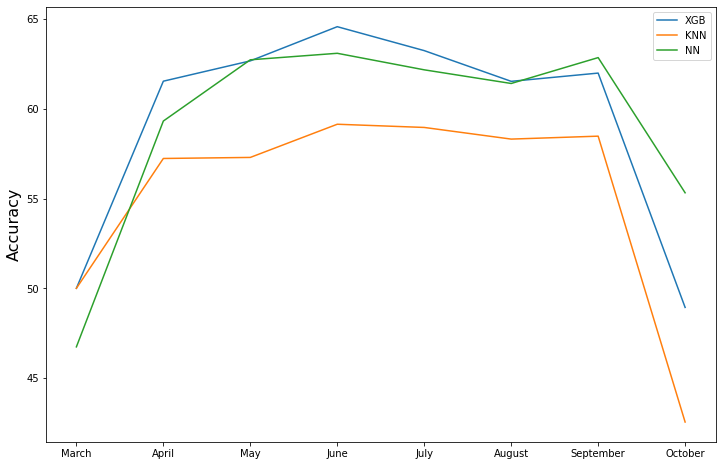

In [81]:
plt.figure(figsize=(12,8))
plt.plot(xgb_month[0]*100, label='XGB')
plt.plot(knn_month[0]*100, label='KNN')
plt.plot(nn_month[0]*100, label='NN')
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(range(8), ['March','April', 'May', 'June','July', 'August', 'September', 'October'])
plt.legend();

## Negative stats

Consider stats like `ops_pct_diff` where a positive value is a strong indicator of a win for the home team. In the case where these stats are _negative_ and yet the home team still wins (or positive but the away team wins), how is each model performing?

In [196]:
tf_test_df['home_win'] = y_test

In [197]:
tf_test_df.head()

,home_team,away_team,Y,M,avg_pct_diff,obp_pct_diff,slg_pct_diff,team_ERA_pct_diff,team_WHIP_pct_diff,team_W-L_pct_diff,...,log_5,xgb_pred,knn_pred,nn_pred,xgb_proba,knn_proba,nn_proba,home_win,knn_no_ops_pred,knn_no_ops_proba
36441,KCA,NYN,2016,4,8.620726,3.092675,2.578581,7.754011,8.007859,5.263158,...,0.5,1,1,1,0.562908,0.533333,0.590414,1,1,0.533333
36442,PIT,SLN,2016,4,2.309712,0.376945,-0.040732,8.978328,-1.211283,-2.040816,...,0.5,1,0,1,0.533676,0.493333,0.563689,1,1,0.506667
36443,TBA,TOR,2016,4,-5.864577,-7.555239,-12.023378,-1.871658,1.468752,-16.250000,...,0.5,0,1,1,0.454400,0.566667,0.666198,0,1,0.593333
36444,ANA,CHN,2016,4,0.398896,-4.950458,-0.794957,14.720812,8.900281,-14.117647,...,0.5,0,0,1,0.450952,0.460000,0.531114,0,0,0.420000
36445,ARI,COL,2016,4,-1.095675,2.427164,-5.196744,-24.444444,-13.778463,13.924051,...,0.5,1,0,1,0.584152,0.446667,0.562535,0,0,0.466667


In [204]:
def negative_stats_acc(df, col, reverse=False):
    if not reverse:
        unusual_df = df[((df[col] > 0) & (df['home_win'] == 0)) | ((df[col] < 0) & (df['home_win'] == 1))]
    else:
        unusual_df = df[((df[col] < 0) & (df['home_win'] == 0)) | ((df[col] > 0) & (df['home_win'] == 1))]
    
    xgb_acc = (unusual_df['xgb_pred'] == unusual_df['home_win']).sum() / unusual_df.shape[0]
    nn_acc = (unusual_df['nn_pred'] == unusual_df['home_win']).sum() / unusual_df.shape[0]
    knn_acc = (unusual_df['knn_pred'] == unusual_df['home_win']).sum() / unusual_df.shape[0]
    knn_no_ops_acc = (unusual_df['knn_no_ops_pred'] == unusual_df['home_win']).sum() / unusual_df.shape[0]
    
    print(f'{"="*10} {col} {"="*10}')
    print(f'XGB acc = {100*xgb_acc:.2f}%')
    print(f'NN acc = {100*nn_acc:.2f}%')
    print(f'KNN acc = {100*knn_acc:.2f}%')
    print(f'KNN (no OPS) acc = {100*knn_no_ops_acc:.2f}%')

In [293]:
reverse_cols = ['team_ERA_pct_diff', 'pitcher_ERA_pct_diff', 'team_WHIP_pct_diff',
                'pitcher_WHIP_pct_diff', 'team_Rank_pct_diff', 'Rank_pct_diff']
pct_diff_cols = [c for c in tf_test_df.columns if c.endswith('_pct_diff')]

In [206]:
for c in reverse_cols:
    pct_diff_cols.remove(c)

In [207]:
for c in pct_diff_cols:
    negative_stats_acc(tf_test_df, c)

========== avg_pct_diff ==========
XGB acc = 31.32%
NN acc = 26.86%
KNN acc = 27.62%
KNN (no OPS) acc = 27.29%
========== obp_pct_diff ==========
XGB acc = 26.99%
NN acc = 24.87%
KNN acc = 24.55%
KNN (no OPS) acc = 24.76%
========== slg_pct_diff ==========
XGB acc = 27.15%
NN acc = 22.95%
KNN acc = 25.77%
KNN (no OPS) acc = 27.76%
========== team_W-L_pct_diff ==========
XGB acc = 51.64%
NN acc = 55.34%
KNN acc = 48.38%
KNN (no OPS) acc = 48.10%
========== team_FP_pct_diff ==========
XGB acc = 59.50%
NN acc = 61.55%
KNN acc = 57.47%
KNN (no OPS) acc = 57.61%
========== R_pct_diff ==========
XGB acc = 54.32%
NN acc = 54.22%
KNN acc = 49.10%
KNN (no OPS) acc = 48.97%
========== RA_pct_diff ==========
XGB acc = 70.13%
NN acc = 67.08%
KNN acc = 70.99%
KNN (no OPS) acc = 71.23%
========== pytha_pct_diff ==========
XGB acc = 50.92%
NN acc = 53.32%
KNN acc = 47.52%
KNN (no OPS) acc = 47.26%
========== win_pct_diff ==========
XGB acc = 52.21%
NN acc = 53.85%
KNN acc = 48.41%
KNN (no OPS) acc = 

In [208]:
for c in reverse_cols:
    negative_stats_acc(tf_test_df, c, reverse=True)

========== team_ERA_pct_diff ==========
XGB acc = 53.05%
NN acc = 55.55%
KNN acc = 49.51%
KNN (no OPS) acc = 49.21%
========== pitcher_ERA_pct_diff ==========
XGB acc = 61.37%
NN acc = 59.52%
KNN acc = 61.23%
KNN (no OPS) acc = 61.41%
========== team_WHIP_pct_diff ==========
XGB acc = 53.26%
NN acc = 55.71%
KNN acc = 50.12%
KNN (no OPS) acc = 49.77%
========== pitcher_WHIP_pct_diff ==========
XGB acc = 56.96%
NN acc = 57.73%
KNN acc = 56.55%
KNN (no OPS) acc = 56.22%
========== team_Rank_pct_diff ==========
XGB acc = 50.88%
NN acc = 55.41%
KNN acc = 47.78%
KNN (no OPS) acc = 47.39%
========== Rank_pct_diff ==========
XGB acc = 50.88%
NN acc = 55.41%
KNN acc = 47.78%
KNN (no OPS) acc = 47.39%


## Ensembling

In [532]:
assert xgb_top10_preds.shape == knn_preds.shape == nn_preds.shape == knn_no_ops_preds.shape == y_test.shape

In [527]:
print('Individual model accuracy:')
print(f'XGB: {100*accuracy_score(y_test, xgb_preds):.2f}%')
print(f'KNN: {100*accuracy_score(y_test, knn_preds):.2f}%')
print(f'KNN (no hitting): {100*accuracy_score(y_test, knn_no_ops_preds):.2f}%')
print(f'NN: {100*accuracy_score(y_test, nn_preds):.2f}%')       

Individual model accuracy:
XGB: 61.08%
KNN: 61.56%
KNN (no hitting): 60.89%
NN: 61.40%


### Correlation between models

In [545]:
from itertools import combinations

preds_names = ['XGB (all)', 'XGB (top 10)', 'KNN (top 10)', 'KNN (top 10, no hitting)', 'NN (top 10)']
preds_list = [xgb_preds, xgb_top10_preds, knn_preds, knn_no_ops_preds, nn_preds]

for idx1, idx2 in combinations(range(len(preds_list)), 2):
    model1 = preds_list[idx1]
    model2 = preds_list[idx2]
    disagree = np.sum(model1 != model2)
    print(f'{preds_names[idx1]} <-> {preds_names[idx2]}: {disagree} disagreed on')
    
    num_correct = 0
    for i in range(y_test.shape[0]):
        if y_test.values[i] in [model1[i], model2[i]]:
            num_correct += 1

    print(f'Maximum possible accuracy = {100*num_correct / y_test.shape[0]:.2f}%')
    print('='*40)

XGB (all) <-> XGB (top 10): 1711 disagreed on
Maximum possible accuracy = 70.34%
XGB (all) <-> KNN (top 10): 1882 disagreed on
Maximum possible accuracy = 70.79%
XGB (all) <-> KNN (top 10, no hitting): 2133 disagreed on
Maximum possible accuracy = 71.71%
XGB (all) <-> NN (top 10): 2038 disagreed on
Maximum possible accuracy = 71.49%
XGB (top 10) <-> KNN (top 10): 1403 disagreed on
Maximum possible accuracy = 69.03%
XGB (top 10) <-> KNN (top 10, no hitting): 1844 disagreed on
Maximum possible accuracy = 70.91%
XGB (top 10) <-> NN (top 10): 1501 disagreed on
Maximum possible accuracy = 69.44%
KNN (top 10) <-> KNN (top 10, no hitting): 921 disagreed on
Maximum possible accuracy = 65.86%
KNN (top 10) <-> NN (top 10): 1536 disagreed on
Maximum possible accuracy = 69.21%
KNN (top 10, no hitting) <-> NN (top 10): 1797 disagreed on
Maximum possible accuracy = 70.19%


In [546]:
for idx1, idx2, idx3 in combinations(range(len(preds_list)), 3):
    model1 = preds_list[idx1]
    model2 = preds_list[idx2]
    model3 = preds_list[idx3]

    num_correct = 0
    for i in range(y_test.shape[0]):
        if y_test.values[i] in [model1[i], model2[i], model3[i]]:
            num_correct += 1
    print(f'{preds_names[idx1]}, {preds_names[idx2]}, {preds_names[idx3]}')
    print(f'Maximum possible accuracy = {100*num_correct / y_test.shape[0]:.2f}%')
    print('='*40)

XGB (all), XGB (top 10), KNN (top 10)
Maximum possible accuracy = 73.94%
XGB (all), XGB (top 10), KNN (top 10, no hitting)
Maximum possible accuracy = 75.46%
XGB (all), XGB (top 10), NN (top 10)
Maximum possible accuracy = 74.49%
XGB (all), KNN (top 10), KNN (top 10, no hitting)
Maximum possible accuracy = 73.46%
XGB (all), KNN (top 10), NN (top 10)
Maximum possible accuracy = 74.85%
XGB (all), KNN (top 10, no hitting), NN (top 10)
Maximum possible accuracy = 75.76%
XGB (top 10), KNN (top 10), KNN (top 10, no hitting)
Maximum possible accuracy = 72.13%
XGB (top 10), KNN (top 10), NN (top 10)
Maximum possible accuracy = 72.81%
XGB (top 10), KNN (top 10, no hitting), NN (top 10)
Maximum possible accuracy = 74.20%
KNN (top 10), KNN (top 10, no hitting), NN (top 10)
Maximum possible accuracy = 71.86%


### Maximum possible accuracy

If we could always pick the "right" model for each row, what is the best possible test accuracy we could get from these three models?

In [530]:
num_correct = 0

for i in range(y_test.shape[0]):
    if y_test.values[i] in [xgb_top10_preds[i], knn_no_ops_preds[i], nn_preds[i]]:
        num_correct += 1

print(f'Maximum possible accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Maximum possible accuracy = 74.20%


### Majority voting

Just pick the prediction that the majority of the models voted for.

In [531]:
num_correct = 0

for i in range(y_test.shape[0]):
    # Just add them up. If at least two models voted 1, then choose 1. Otherwise choose 0.
    majority_vote = np.sum([xgb_top10_preds[i], knn_no_ops_preds[i], nn_preds[i]])
    if majority_vote > 1:
        majority_vote = 1
    else:
        majority_vote = 0
    if y_test.values[i] == majority_vote:
        num_correct += 1

print(f'Majority voting accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Majority voting accuracy = 62.14%


### Number of positive columns
Choose a KNN when the number of positive columns (from list below) is < 5, and the NN when it's greater than 5. This work/idea comes from the `Comparing model predictions` notebook.

In [474]:
pct_diff_cols = [c for c in cols if c.endswith('_pct_diff')]
pct_diff_reverse_cols = ['pitcher_WHIP_pct_diff', 'team_Rank_pct_diff', 
                         'team_WHIP_pct_diff', 'team_ERA_pct_diff', 'pitcher_ERA_pct_diff',
                         'team_RA_pct_diff']
pct_diff_reverse_cols = list(set(pct_diff_cols).intersection(pct_diff_reverse_cols))

for c in pct_diff_reverse_cols:
    pct_diff_cols.remove(c)

In [488]:
num_correct = 0

for i in range(y_test.shape[0]):
    # Just add them up. If at least two models voted 1, then choose 1. Otherwise choose 0.
    vote = np.sum([knn_no_ops_preds[i], nn_preds[i]])
    if vote == 2:
        vote = 1
    elif vote == 0:
        vote = 0
    elif (test_df.iloc[i][pct_diff_cols] > 0).sum() >= 5:
        vote = knn_no_ops_preds[i]
    else:
        vote = nn_preds[i]
        
    if y_test.values[i] == vote:
        num_correct += 1

print(f'Majority voting accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Majority voting accuracy = 61.81%


In [489]:
num_correct = 0

for i in range(y_test.shape[0]):
    # Just add them up. If at least two models voted 1, then choose 1. Otherwise choose 0.
    vote = np.sum([knn_no_ops_preds[i], nn_preds[i]])
    if vote == 2:
        vote = 1
    elif vote == 0:
        vote = 0
    elif (test_df.iloc[i][pct_diff_reverse_cols] < 0).sum() >= 4:
        vote = knn_no_ops_preds[i]
    else:
        vote = nn_preds[i]
        
    if y_test.values[i] == vote:
        num_correct += 1

print(f'Majority voting accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Majority voting accuracy = 61.82%


In [491]:
num_correct = 0

for i in range(y_test.shape[0]):
    # Just add them up. If at least two models voted 1, then choose 1. Otherwise choose 0.
    vote = np.sum([knn_no_ops_preds[i], nn_preds[i]])
    if vote == 2:
        vote = 1
    elif vote == 0:
        vote = 0
    elif test_df.iloc[i]['team_bayes_pct_diff'] > 0:
        vote = nn_preds[i]
    else:
        vote = knn_no_ops_preds[i]
        
    if y_test.values[i] == vote:
        num_correct += 1

print(f'Majority voting accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Majority voting accuracy = 61.71%


## Recording predictions

Save a dataframe with the predictions for each model.

In [481]:
test_df_nn.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,away_pitcher_IP_avg_162games,team_Rank_pct_diff,home_pitcher_IP_avg_162games,away_RD,home_pitcher_WHIP_avg_162games,Y,M,home_win,home_team,away_team
37193,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,5.485714,0.50,5.480001,122.0,1.390555,2016,4.0,1.0,PIT,SLN
37194,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,5.485714,0.75,5.480001,221.0,1.390555,2016,4.0,0.0,TBA,TOR
37195,0.028053,0.009820,0.030927,1.0,1.179045,0.077540,-0.010464,83.0,0.0,-0.010464,...,5.485714,0.00,5.480001,70.0,1.390555,2016,4.0,1.0,KCA,NYN
37196,0.031095,0.006132,0.019876,5.0,1.320066,0.043269,-0.010464,-35.0,0.0,-0.010464,...,5.485714,0.20,5.480001,-79.0,1.390555,2016,4.0,0.0,OAK,CHA
37197,-0.026164,-0.014945,-0.049505,3.0,1.151872,0.147208,-0.010464,-14.0,0.0,-0.010464,...,5.485714,0.00,5.480001,81.0,1.390555,2016,4.0,0.0,ANA,CHN


In [ ]:
test_df_nn['home_team'] = le.inverse_transform(test_df_nn['home_team'])
test_df_nn['away_team'] = le.inverse_transform(test_df_nn['away_team'])

In [483]:
test_df_nn.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,away_pitcher_IP_avg_162games,team_Rank_pct_diff,home_pitcher_IP_avg_162games,away_RD,home_pitcher_WHIP_avg_162games,Y,M,home_win,home_team,away_team
37193,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,5.485714,0.50,5.480001,122.0,1.390555,2016,4.0,1.0,PIT,SLN
37194,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,5.485714,0.75,5.480001,221.0,1.390555,2016,4.0,0.0,TBA,TOR
37195,0.028053,0.009820,0.030927,1.0,1.179045,0.077540,-0.010464,83.0,0.0,-0.010464,...,5.485714,0.00,5.480001,70.0,1.390555,2016,4.0,1.0,KCA,NYN
37196,0.031095,0.006132,0.019876,5.0,1.320066,0.043269,-0.010464,-35.0,0.0,-0.010464,...,5.485714,0.20,5.480001,-79.0,1.390555,2016,4.0,0.0,OAK,CHA
37197,-0.026164,-0.014945,-0.049505,3.0,1.151872,0.147208,-0.010464,-14.0,0.0,-0.010464,...,5.485714,0.00,5.480001,81.0,1.390555,2016,4.0,0.0,ANA,CHN


In [485]:
test_df_nn['xgb_pred'] = xgb_preds
test_df_nn['knn_pred'] = knn_preds
test_df_nn['knn_no_batting_pred'] = knn_no_ops_preds
test_df_nn['nn_pred'] = nn_preds
test_df_nn['nn_pred'] = test_df_nn['nn_pred'].astype(int)

test_df_nn['xgb_proba'] = xgb_proba_preds[:, 1]
test_df_nn['knn_proba'] = knn_proba_preds[:, 1]
test_df_nn['knn_no_batting_proba'] = knn_no_ops_proba_preds[:, 1]
test_df_nn['nn_proba'] = nn_softmax_preds.numpy()

In [486]:
test_df_nn.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,home_team,away_team,xgb_pred,knn_pred,knn_no_batting_pred,nn_pred,xgb_proba,knn_proba,knn_no_batting_proba,nn_proba
37193,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,PIT,SLN,0.0,0.0,1.0,0,0.452681,0.500000,0.520000,0.455505
37194,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,TBA,TOR,0.0,0.0,1.0,0,0.377228,0.473333,0.506667,0.395637
37195,0.028053,0.009820,0.030927,1.0,1.179045,0.077540,-0.010464,83.0,0.0,-0.010464,...,KCA,NYN,1.0,1.0,1.0,1,0.629717,0.533333,0.546667,0.508145
37196,0.031095,0.006132,0.019876,5.0,1.320066,0.043269,-0.010464,-35.0,0.0,-0.010464,...,OAK,CHA,1.0,0.0,1.0,1,0.572504,0.486667,0.506667,0.525333
37197,-0.026164,-0.014945,-0.049505,3.0,1.151872,0.147208,-0.010464,-14.0,0.0,-0.010464,...,ANA,CHN,1.0,0.0,0.0,0,0.515874,0.486667,0.486667,0.497620


In [487]:
test_df_nn.to_csv('../data/Final Data/start_to_finish_with_preds.csv', index=False)

### For Training Predictions

In [ ]:
xgb_train_pred = xgb_clf.predict(X_train)
knn_no_train_pred = knn_no_ops_clf.predict(X_train_scaled_no_ops)
nn_train_logit_preds = model.predict(train_ds).squeeze()
nn_train_softmax_preds = tf.nn.sigmoid(nn_train_logit_preds)
nn_train_pred = tf.round(nn_train_softmax_preds).numpy()

In [ ]:
tf_train_df['home_team'] = le.inverse_transform(tf_train_df['home_team'])
tf_train_df['away_team'] = le.inverse_transform(tf_train_df['away_team'])

In [ ]:
tf_train_df['xgb_train_pred'] = xgb_train_pred
tf_train_df['knn_no_batting_train_pred'] = knn_no_train_pred
tf_train_df['nn_train_pred'] = nn_train_pred
tf_train_df['nn_train_pred'] = tf_train_df['nn_train_pred'].astype(int)

In [ ]:
tf_train_df['home_win'] = y_train

In [ ]:
tf_train_df.to_csv('../data/Final Data/training_with_preds.csv', index=False)